$
\newcommand{\Tau}{\mathcal{T}}
\newcommand{\bm}[1]{{\boldsymbol{#1}}}
\newcommand{\dt}[1]{{\frac{d#1}{dt}}}
%\newcommand{\bm}{\mathbf{#1}}
\newcommand{\trsp}{{\scriptscriptstyle\top}}$


# Running the script

**Sequentially SHIFT + ENTER on each cell** 

- You can change the number of gaussians in block [224] by changing the nb_states value.
- Block [242] creates the model and the value of mu and sigma is stored in saved mu and savedsigma 
- Can skip block [228]
- Block [228] and block [229] do the reconstruction and plot it. You can change the delta value and the number of iterations in this block. These ones have a commented description above. Block 285 is what Jakub needs to paste in to the C++ file. It's really cool!




# Regression between time series

In this notebook, we consider the problem of regression between time series. We have two time series $\{\bm{\xi}_t^{IN}\}_{t=0}^{N}$ and $\{\bm{\xi}_t^{OUT}\}_{t=0}^{N}$ that happen simultaneously and are dependent. The goal is to predict $\{\bm{\xi}_t^{OUT}\}_{t=0}^{N}$ given observation of full or partial sequence $IN$. 

In the context of Programming by Demonstration, and more precisely in assistive robotics, this could be applied to problems where the robot has to react or synchronize to a human user. The two time series refer to variable describing the human and the robot actuation. They are examples of the task to learn. During the execution of the task, the robot actuation needs to be adapted to the human which can be seen as a regression with, as input, the human time serie and, as output, the robot actuation.

We compare three different regression techniques:

***Gaussian Mixture Regression (GMR)***

The first is [Gaussian Mixture Regression (GMR)](http://mlg.eng.cam.ac.uk/zoubin/papers/nips93.pdf) and is based on computing conditional probability in a joint density encoded by a Gaussian Mixture Model (GMM). This technique does not consider any temporal dependency. 

***Hidden Markov Model (HMM)***

In the second, the joint density between the two time series is encoded as an [Hidden Markov Model (HMM)](http://www.ece.ucsb.edu/Faculty/Rabiner/ece259/Reprints/tutorial%20on%20hmm%20and%20applications.pdf), which adds an temporal dependency. 

***Hidden Semi-Markov Model (HSMM)***

Finally, we use [Hidden Semi-Markov model (HSMM)](http://www.cs.ubc.ca/~murphyk/papers/segment.pdf) which allows for more precise encoding of the durations of states. 

For this notebook, we use dataset of handwriting letters. One letter is the input, another is the output.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat # loading data from matlab
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import pbdlib as pbd
import pbdlib.plot 
from pbdlib.utils.jupyter_utils import *
np.set_printoptions(precision=2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
pwd

u'/home/hulk/Compiles_New/pbdlib-python/notebooks'

# Example 1 : Disambiguation

In this first example, we show the advantage of encoding temporal dependencies through Markovian model. It is useful to disambiguate situations by taking into account the past. 

In [41]:
########################################################################
##################CHANGE VALEUES HERE###################################
########################################################################
num_traj = 10

nb_states = 3  # choose the number of states in HMM or clusters in GMM

delt = .01

num_traj_points = 300
########################################################################
########################################################################

### Loading dataset

In this example, letter **X** is used as input and **C** as output. The intersection of the **X** is an ambiguous position. In order to be able to localize in the writing process, history should be taken into account : we have to know which of the two strokes we were doing.

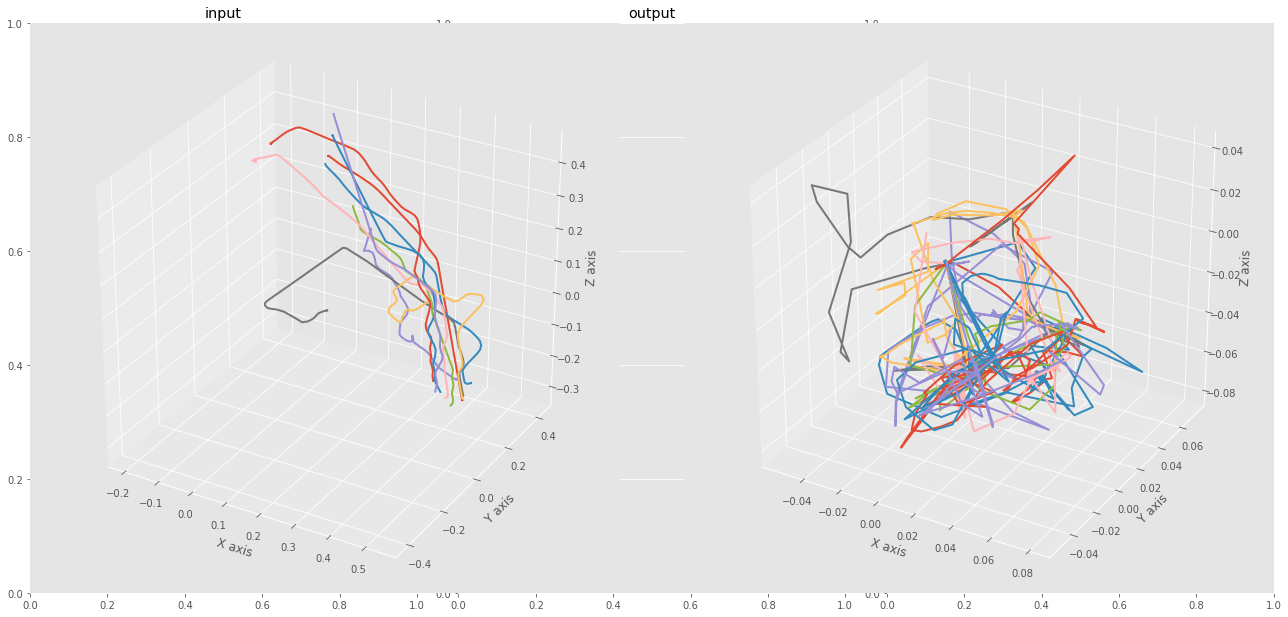

In [42]:
letter_in = 'traj_kinova' # INPUT LETTER: choose a letter in the alphabet

#datapath = os.path.dirname(pbd.__file__) + '/data/RobotData/'

#data_in = loadmat(datapath + '%s.mat' % letter_in)
data_in = loadmat('%s.mat' % letter_in)

demos_in = [d['pos'][0][0].T for d in data_in['posdemos'][0]] # cleaning matlab data
demos_out = [d['vel'][0][0].T for d in data_in['veldemos'][0]] # cleaning matlab data

demos = [np.concatenate([d_in, d_out], axis=1) 
         for d_in, d_out in zip(demos_in, demos_out)]

fig, ax = plt.subplots(ncols=3)  
fig.set_size_inches(18., 8.5)
plt.tight_layout()

[ax[i].set_title(s) for i, s in enumerate(['input', 'output'])]

ax = fig.add_subplot(1,2,1, projection = '3d')
A = np.arange(num_traj_points)
B = np.arange(num_traj)
for l in B:
    x = np.array(demos_in[l])
    xp = x[:,0]
    yp = x[:,1]
    zp = x[:,2]  
    
    ax.plot3D(xp,yp,zp, linewidth = 2, antialiased=True)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

ax = fig.add_subplot(1,2,2, projection = '3d')
B = np.arange(num_traj)
for l in B:
    x = np.array(demos_out[l])
    xp = x[:,0]
    yp = x[:,1]
    zp = x[:,2]  

    ax.plot3D(xp,yp,zp, linewidth = 2, antialiased=True)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

#plt.tight_layout()   


### Training  models

We train a GMM, HMM and HSMM over the concatenation of input and output time series. These models encode the joint probability of input-output. The states (or clusters) are Multivariate Normal Distributions (MVNs) with full covariance matrix. The mean and covariance can be decomposed and displayed the following way : 

$\bm{\mu}_i = \begin{bmatrix} \bm{\mu}_i^{IN} \\  \bm{\mu}_i^{OUT} \end{bmatrix},\quad 
\bm{\Sigma}_i = \begin{bmatrix} \bm{\Sigma}_i^{IN} & \bm{\Sigma}_i^{IN, OUT} \\
 \bm{\Sigma}_i^{OUT, IN} & \bm{\Sigma}_i^{OUT} \end{bmatrix}$

In [43]:
np.stack(demos).shape

(10, 90, 6)

In [44]:
# creating models
gmm = pbd.GMM(nb_states=nb_states)
hmm = pbd.HMM(nb_states=nb_states)
hsmm = pbd.HSMM(nb_states=nb_states)

# initializing model by splitting the demonstrations in k bins
[model.init_hmm_kbins(demos) for model in [gmm, hmm, hsmm]] 

# EM to train model
gmm.em(np.concatenate(demos), reg=1e-8) 
hmm.em(np.stack(demos), reg=1e-8) 
hsmm.em(demos, reg=1e-6) 

#THIS IS THE SAVED SIGMA AND MU VALUES
# savedsigma = gmm.sigma
# savedmu = gmm.mu

savedsigma = gmm.sigma
savedmu = gmm.mu 

file1 = open("/home/hulk/Documents/waypoints/f1.txt","w") 

L = np.array2string(savedmu, precision=4, separator=',', suppress_small=True)  
file1.writelines(L)
file1.write("\n")
L = np.array2string(savedsigma, precision=4, separator=',', suppress_small=True)  
file1.writelines(L)
file1.write("\n")


EM converges
EM converges


### Computing states activations
As a first step for regression, we compute the activation of each state (or cluster), given the input sequence. 

***GMM***

For GMM, the activation of state $i$ at time step $t$ is defined as :
\begin{align*}
h_{t,i} = \frac{\pi_i \;
	\mathcal{N}(\bm{\xi}_t^{IN}|\,\bm{\mu}_i^{IN},\bm{\Sigma}_i^{IN})}{\sum_{k=1}^{K}\pi_k \;
	\mathcal{N}(\bm{\xi}_t^{IN}|\,\bm{\mu}_k^{IN},\bm{\Sigma}_k^{IN})}
\end{align*}

***HMM-HSMM***

For HMM and HSMM the activations are based on [forward messages](https://en.wikipedia.org/wiki/Forward%E2%80%93backward_algorithm) $\alpha_{t,i}$.

\begin{equation}
  h_{t,i} = \frac{\alpha_{t,i}}{\sum_{k=1}^K \alpha_{t,k}} ,
  \quad\mathrm{with}\quad
  \alpha_{t,i} = \Big(\sum\limits_{j=1}^K \alpha_{t-1,j}\; A_{j,i}\Big) \;
	\mathcal{N}\big(\bm{\xi}^{IN}_t |\;\bm{\mu}^{IN}_i,\bm{\Sigma}^{IN}_i\big) ,
\end{equation}

where $A$ is the HMM transition matrix. These activations takes into account the temporal dependencies.





In [45]:
# n = 0

# resp_gmm = gmm.compute_resp(demos_in[n], marginal=slice(0, 3))

# alpha_hmm, _, _, _, _ = hmm.compute_messages(
#     demos_in[n], marginal=slice(0, 3))

# alpha_hsmm, _, _, _, _ = hsmm.compute_messages(
#     demos_in[n], marginal=slice(0, 3))


# fig, ax = plt.subplots(nrows=3)
# fig.set_size_inches(7.5,3.6)

# ax[0].plot(resp_gmm.T , lw=1);
# ax[1].plot(alpha_hmm.T, lw=1);
# ax[2].plot(alpha_hsmm.T, lw=1);

# [ax[i].set_ylim([-0.2, 1.2]) for i in range(3)]
# plt.xlabel('timestep');

With the GMM, there is an ambiguity in the activation at the intersection of the **X**. Multiple states are activate and we cannot distinguish from which one to regenerate the output letter **C**. Adding temporal dependencies through Markov models removes these ambiguities by modeling the sequencing of the states.

### Reconstruction
If we now regenerate the output letters from these activation, the GMM gives a poor reconstruction, that jumps from parts to parts of the output letter. In this example, the advantages of the HSMM is not clear but this will be explained in the next. 

In [46]:
from numpy import array

y = np.array([.5,.1,.1])
y.shape = (1,3)

mu_est_gmm, sigma_est_gmm = gmm.condition(
    y, dim_in=slice(0, 3), dim_out=slice(3, 6))
# mu_est_hmm, sigma_est_hmm = hmm.condition(
#     y, dim_in=slice(0, 3), dim_out=slice(3, 6))
# mu_est_hsmm, sigma_est_hsmm = hsmm.condition(
#     y, dim_in=slice(0, 3), dim_out=slice(3, 6))


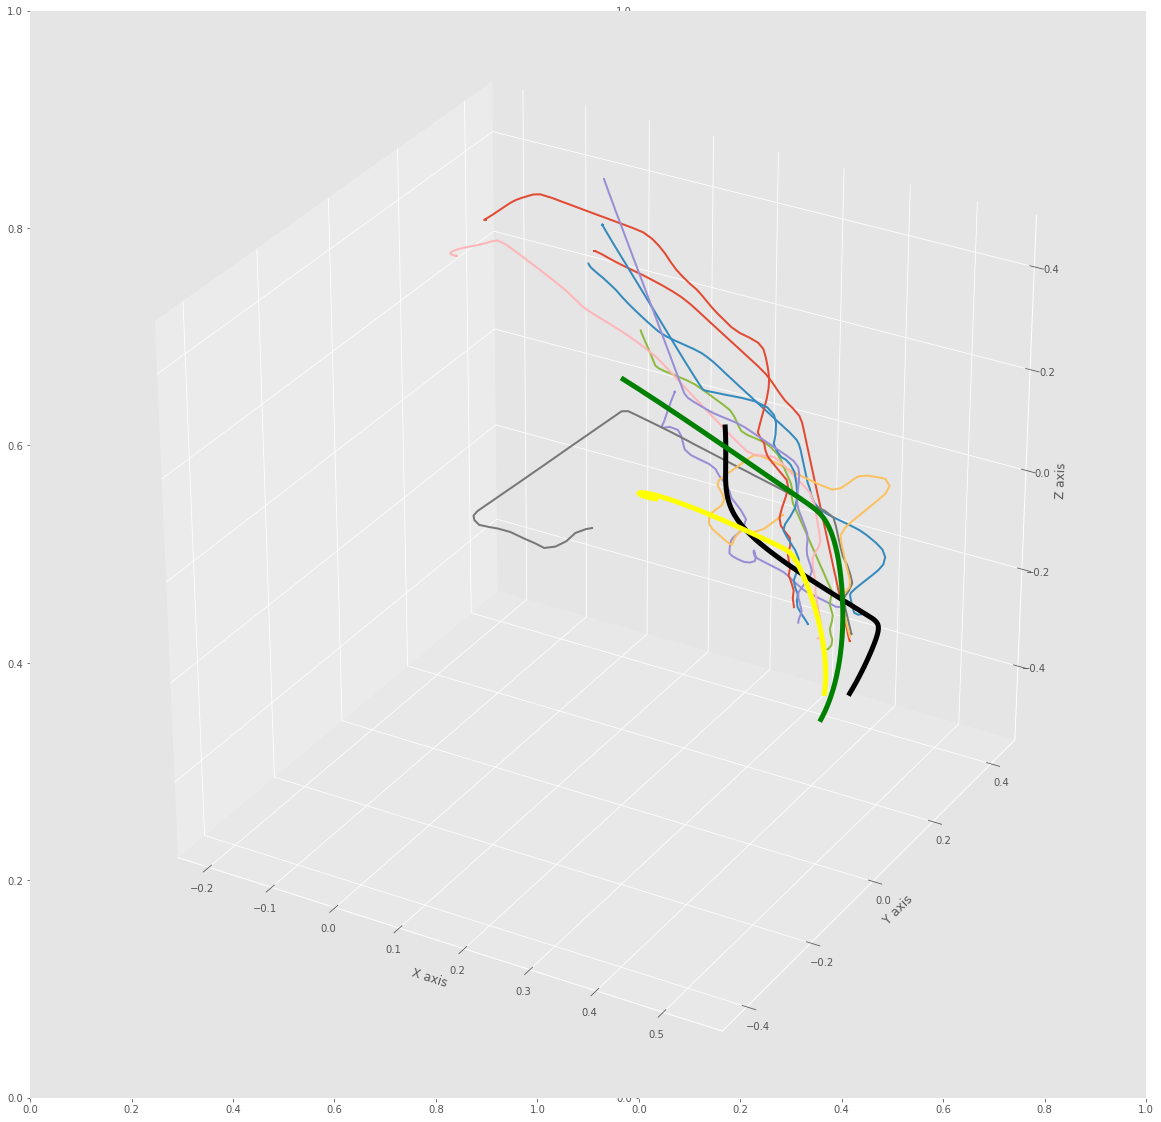

In [52]:
fig.set_size_inches(25, 15)
file1 = open("/home/hulk/Documents/waypoints/f1.txt","w") 
A = np.arange(num_traj_points)


y = array([.45,-.2,.4])
y.shape = (1,3)

#CAN CHANGE DELTA VALUE HERE
delt = .1
pos = array([0,0,0])
pos.shape = (1,3)
pos = y + mu_est_gmm*delt

#3D VERSION
#CAN CHANGE THE NUMBER OF ITERATIONS HERE
for j in A:
    temp = pos[j]
    temp.shape = (1,3) 
    mu_est_gmm, sigma_est_gmm = gmm.condition(temp, dim_in=slice(0, 3), dim_out=slice(3, 6))
    newpos = temp + mu_est_gmm*delt
    newpos.shape = (1,3)
    finalresult = np.concatenate((pos,newpos),axis=0)
    pos = finalresult

fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(20., 20)
ax = fig.add_subplot(1,1,1, projection = '3d')



C = np.arange(num_traj)
for m in C:
    x = np.array(demos_in[m])
    xp = x[:,0]
    yp = x[:,1]
    zp = x[:,2]  
    ax.plot3D(xp,yp,zp, linewidth = 2, antialiased=True)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

ax.plot3D(pos[:,0],pos[:,1],pos[:,2],linewidth = 5, color='black')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')


y = array([.2,0.0,.3])
y.shape = (1,3)
mu_est_gmm, sigma_est_gmm = gmm.condition(
    y, dim_in=slice(0, 3), dim_out=slice(3, 6))

pos = array([0,0,0])
pos.shape = (1,3)
pos = y + mu_est_gmm*delt

for j in A:
    temp = pos[j]
    temp.shape = (1,3) 
    mu_est_gmm, sigma_est_gmm = gmm.condition(temp, dim_in=slice(0, 3), dim_out=slice(3, 6))
    newpos = temp + mu_est_gmm*delt
    newpos.shape = (1,3)
    finalresult = np.concatenate((pos,newpos),axis=0)
    pos = finalresult

ax.plot3D(pos[:,0],pos[:,1],pos[:,2],linewidth = 5, color='green')



y = array([.5,.25,.25])
y.shape = (1,3)
mu_est_gmm, sigma_est_gmm = gmm.condition(
    y, dim_in=slice(0, 3), dim_out=slice(3, 6))

pos = array([0,0,0])
pos.shape = (1,3)
pos = y + mu_est_gmm*delt

y = array([.4,-.3,.3])
y.shape = (1,3)
mu_est_gmm, sigma_est_gmm = gmm.condition(
    y, dim_in=slice(0, 3), dim_out=slice(3, 6))

pos = array([0,0,0])
pos.shape = (1,3)
pos = y + mu_est_gmm*delt

for j in A:
    temp = pos[j]
    temp.shape = (1,3) 
    mu_est_gmm, sigma_est_gmm = gmm.condition(temp, dim_in=slice(0, 3), dim_out=slice(3, 6))
    newpos = temp + mu_est_gmm*delt
    newpos.shape = (1,3)
    finalresult = np.concatenate((pos,newpos),axis=0)
    pos = finalresult

ax.plot3D(pos[:,0],pos[:,1],pos[:,2],linewidth = 5, color='yellow')

file1.close() #to change file access modes 




# i = 0.1
# c = 0 
# traj= np.zeros((20, num_traj_points + 1, 3))

# while i < .4:
#     y = array([.6,.25,i])
#     y.shape = (1,3)
#     mu_est_gmm, sigma_est_gmm = gmm.condition(
#         y, dim_in=slice(0, 3), dim_out=slice(3, 6))

#     pos = array([0,0,0])
#     pos.shape = (1,3)
#     pos = y + mu_est_gmm*delt

#     for j in A:
#         temp = pos[j]
#         temp.shape = (1,3) 
#         mu_est_gmm, sigma_est_gmm = gmm.condition(temp, dim_in=slice(0, 3), dim_out=slice(3, 6))
#         newpos = temp + mu_est_gmm*delt
#         newpos.shape = (1,3)
#         finalresult = np.concatenate((pos,newpos),axis=0)
#         pos = finalresult

#     traj[c] = pos
#     c = c + 1

#     ax.plot3D(pos[:,0],pos[:,1],pos[:,2],linewidth = 3, color='cyan')
#     i += 0.05

In [101]:
#VALUES TO BE SENT TO JAKUB
#savedsigma and savedmu

In [112]:
#print("MU")
# print(savedmu)
#print("SIGMA")
# print(savedsigma)
print("model.nb_var = {}; //number of variables in the model".format(6))
print("model.parameters.nb_states = {};  //number of gaussians".format(nb_states))
print("model.priors = vec(model.parameters.nb_states);")
print("vec mu_tmp_arma(model.parameters.nb_states);")
print("mat sigma_mat_tmp(model.nb_var,model.nb_var);")
print("")
for i in range(len(savedmu)):
        #print("mu_tmp_arma << {} << {} << {} << {} << {} << {};".format(savedmu[i][0],savedmu[i][1],savedmu[i][2],savedmu[i][3],savedmu[i][4],savedmu[i][5]))
        #print("model.mu.push_back(mu_tmp_arma);")
        print("mu_tmp_arma",end = "")
        for j in range(len(savedmu[i])):
            print(" << {}".format(savedmu[i][j]),end = "")
        print(";")
        print("model.mu.push_back(mu_tmp_arma);")
print("")
for i in range(len(savedsigma)):
    print("sigma_mat_tmp",end = "")
    for j in range(len(savedsigma[i])):
        for k in range(len(savedsigma[i][j])):
            if k == 0 and j != 0:
                print("\t\t\t  ",end = "")
                print("<< {}".format(savedsigma[i][j][k]), end = "")
            else:   
                print(" << {}".format(savedsigma[i][j][k]), end = "")
        print(" << endr", end = "")
        if j != (len(savedsigma[i])-1):
            print("")
    print(";")
    print("model.sigma.push_back(sigma_mat_tmp);")
    print("")

print("model.priors",end = "")
for i in range(len(gmm.priors)):
    print(" << {}".format(gmm.priors[i]),end = "")
print(";")

model.nb_var = 6; //number of variables in the model
model.parameters.nb_states = 3;  //number of gaussians
model.priors = vec(model.parameters.nb_states);
vec mu_tmp_arma(model.parameters.nb_states);
mat sigma_mat_tmp(model.nb_var,model.nb_var);

mu_tmp_arma << 0.7881936799823732 << -0.2505932034640237 << -0.06018154444618127 << 0.0007853584567789446 << 2.6939995041864467e-05 << -0.002402086722654975;
model.mu.push_back(mu_tmp_arma);
mu_tmp_arma << 0.5271894047930549 << 0.16184034495415348 << 0.2239569457788073 << 0.013979553086605619 << -0.0096035326949687 << -0.004578806976615848;
model.mu.push_back(mu_tmp_arma);
mu_tmp_arma << 0.6896086036866731 << -0.2753645169770703 << 0.06298456560969554 << 0.0068392527896363785 << 0.00037628443375895085 << -0.005997328004604243;
model.mu.push_back(mu_tmp_arma);

sigma_mat_tmp << 0.00019927537238049176 << 0.00015106391631182066 << 8.983704607875129e-05 << -2.14260118142352e-05 << -9.986455101471212e-06 << 1.2341965986654445e-06 << endr
			  << 0

In [69]:
#JUST TO CHECK THE FORMAT

model.nb_var = 6; //number of variables in the model
	model.parameters.nb_states = 5; //number of gaussians

	//iterate

	mu_tmp_arma << 1 << 1 << 1 << 1 << 1 << 1;
	model.mu.push_back(mu_tmp_arma);
	mu_tmp_arma << 1 << 1 << 1 << 1 << 1 << 1;
	model.mu.push_back(mu_tmp_arma);
	mu_tmp_arma << 1 << 1 << 1 << 1 << 1 << 1;
	model.mu.push_back(mu_tmp_arma);
	mu_tmp_arma << 1 << 1 << 1 << 1 << 1 << 1;
	model.mu.push_back(mu_tmp_arma);
	mu_tmp_arma << 1 << 1 << 1 << 1 << 1 << 1;
	model.mu.push_back(mu_tmp_arma);
	mu_tmp_arma << 1 << 1 << 1 << 1 << 1 << 1;
	model.mu.push_back(mu_tmp_arma);

	sigma_mat_tmp << 1 << 1 << 1 << 1 << 1 << 1 << endr
				  << 1 << 1 << 1 << 1 << 1 << 1 << endr
				  << 1 << 1 << 1 << 1 << 1 << 1 << endr
				  << 1 << 1 << 1 << 1 << 1 << 1 << endr
				  << 1 << 1 << 1 << 1 << 1 << 1 << endr
				  << 1 << 1 << 1 << 1 << 1 << 1 << endr;	  
	model.sigma.push_back(sigma_mat_tmp);
	sigma_mat_tmp << 1 << 1 << 1 << 1 << 1 << 1 << endr
				  << 1 << 1 << 1 << 1 << 1 << 1 << endr
				  << 1 << 1 << 1 << 1 << 1 << 1 << endr
				  << 1 << 1 << 1 << 1 << 1 << 1 << endr
				  << 1 << 1 << 1 << 1 << 1 << 1 << endr
				  << 1 << 1 << 1 << 1 << 1 << 1 << endr;	  
	model.sigma.push_back(sigma_mat_tmp);
	sigma_mat_tmp << 1 << 1 << 1 << 1 << 1 << 1 << endr
				  << 1 << 1 << 1 << 1 << 1 << 1 << endr
				  << 1 << 1 << 1 << 1 << 1 << 1 << endr
				  << 1 << 1 << 1 << 1 << 1 << 1 << endr
				  << 1 << 1 << 1 << 1 << 1 << 1 << endr
				  << 1 << 1 << 1 << 1 << 1 << 1 << endr;	  
	model.sigma.push_back(sigma_mat_tmp);
	sigma_mat_tmp << 1 << 1 << 1 << 1 << 1 << 1 << endr
				  << 1 << 1 << 1 << 1 << 1 << 1 << endr
				  << 1 << 1 << 1 << 1 << 1 << 1 << endr
				  << 1 << 1 << 1 << 1 << 1 << 1 << endr
				  << 1 << 1 << 1 << 1 << 1 << 1 << endr
				  << 1 << 1 << 1 << 1 << 1 << 1 << endr;	  
	model.sigma.push_back(sigma_mat_tmp);
	sigma_mat_tmp << 1 << 1 << 1 << 1 << 1 << 1 << endr
				  << 1 << 1 << 1 << 1 << 1 << 1 << endr
				  << 1 << 1 << 1 << 1 << 1 << 1 << endr
				  << 1 << 1 << 1 << 1 << 1 << 1 << endr
				  << 1 << 1 << 1 << 1 << 1 << 1 << endr
				  << 1 << 1 << 1 << 1 << 1 << 1 << endr;	  
	model.sigma.push_back(sigma_mat_tmp);
	sigma_mat_tmp << 1 << 1 << 1 << 1 << 1 << 1 << endr
				  << 1 << 1 << 1 << 1 << 1 << 1 << endr
				  << 1 << 1 << 1 << 1 << 1 << 1 << endr
				  << 1 << 1 << 1 << 1 << 1 << 1 << endr
				  << 1 << 1 << 1 << 1 << 1 << 1 << endr
				  << 1 << 1 << 1 << 1 << 1 << 1 << endr;	  
	model.sigma.push_back(sigma_mat_tmp);
	sigma_mat_tmp << 1 << 1 << 1 << 1 << 1 << 1 << endr
				  << 1 << 1 << 1 << 1 << 1 << 1 << endr
				  << 1 << 1 << 1 << 1 << 1 << 1 << endr
				  << 1 << 1 << 1 << 1 << 1 << 1 << endr
				  << 1 << 1 << 1 << 1 << 1 << 1 << endr
				  << 1 << 1 << 1 << 1 << 1 << 1 << endr;	  
	model.sigma.push_back(sigma_mat_tmp);
	//iterate

	model.priors << 1 << 1 << 1 << 1 << 1 << 1;

SyntaxError: invalid syntax (<ipython-input-69-97c53dffca21>, line 3)

In [11]:
#LEAVE THE REST OUT

# Example 2
In the first example, there was a strong dependence between the two time series in the sense that the sequence of state and its timing can be precisely determined by the input sequence. For illustrating this, imagine making an high-five to a robot. The robot does not need to precisely know the timing of the gesture as it can rely on you to give it and just synchronize.  

However, in some cases, the timing should be more precisely known by the robot. For example, if the robot should follow a complex procedure with precise timing while you don't move. In the HMM, the timing is not explicitly encoded. It is done only implicitly through the transition matrix and the self transition probability $A_{i,i}$. In HSMM, this self transition is set to $0$ and the duration is encoded as a countdown timer whose duration follow a distribution of time, allowing a more precise retrieval of the temporal characteristics of a task.

### Dataset
For this example, the input is just Gaussian noise, which does not gives any information on the output.

In [12]:
#DO NOT READ

In [13]:
datapath = os.path.dirname(pbd.__file__) + '/data/RobotData/'

letter_out = 'right_traj' # choose a letter in the alphabet

data_out = loadmat(datapath + '%s.mat' % letter_out)

#pint(data_out)
demos_out = [d['pos'][0][0].T for d in data_out['demos'][0]] 
demos_in = [np.random.multivariate_normal(np.zeros(2), np.eye(2), d.shape[0]) 
            for d in demos_out] 

demos = [np.concatenate([d_in, d_out], axis=1) 
         for d_in, d_out in zip(demos_in, demos_out)]

EM did not converge
EM did not converge


IndexError: index 2 is out of bounds for axis 0 with size 2

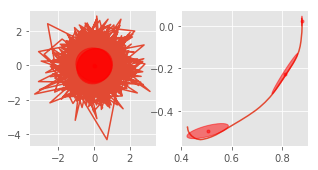

In [14]:
nb_states = 3  # choose the number of states in HMM or clusters in GMM

gmm = pbd.GMM(nb_states=nb_states)
hmm = pbd.HMM(nb_states=nb_states)
hsmm = pbd.HSMM(nb_states=nb_states)

# initializing model
[model.init_hmm_kbins(demos) for model in [gmm, hmm, hsmm]] 

# EM to train model
gmm.em(np.concatenate(demos), reg=1e-3) 
hmm.em(demos, reg=1e-3) 
hsmm.em(demos, reg=1e-3) 

# plotting demos
fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(5., 2.5)

for p_in, p_out in zip(demos_in, demos_out):
    ax[0].plot(p_in[:, 0], p_in[:, 1])
    ax[1].plot(p_out[:, 0], p_out[:, 1])    
    
# use dim for selecting dimensions of GMM to plot
pbd.plot_gmm(gmm.mu, gmm.sigma, ax=ax[0], dim=[0, 1]);
pbd.plot_gmm(gmm.mu, gmm.sigma, ax=ax[1], dim=[2, 3]); 
pbd.plot_gmm(hmm.mu, hmm.sigma, ax=ax[2], dim=[2, 3]); 

#### Compute messages with marginal probabilities

In [ ]:
n = 0

resp_gmm = gmm.compute_resp(demos_in[n], marginal=slice(0, 2))
alpha_hsmm, _, _, _, _ = hsmm.compute_messages(
    demos_in[n], marginal=slice(0, 2))
alpha_hmm, _, _, _, _ = hmm.compute_messages(
    demos_in[n], marginal=slice(0, 2))


fig, ax = plt.subplots(nrows=3)
fig.set_size_inches(7.5,3.6)

ax[0].plot(resp_gmm.T , lw=1);
ax[1].plot(alpha_hmm.T, lw=1);
ax[2].plot(alpha_hsmm.T, lw=1);

[ax[i].set_ylim([-0.2, 1.2]) for i in range(3)]
plt.xlabel('timestep');

In [ ]:
mu_est_gmm, sigma_est_gmm = gmm.condition(
    demos_in[1], dim_in=slice(0, 2), dim_out=slice(2, 4))
mu_est_hmm, sigma_est_hmm = hmm.condition(
    demos_in[1], dim_in=slice(0, 2), dim_out=slice(2, 4))
mu_est_hsmm, sigma_est_hsmm = hsmm.condition(
    demos_in[1], dim_in=slice(0, 2), dim_out=slice(2, 4))

In [ ]:
fig, ax = plt.subplots(ncols=5)
fig.set_size_inches(14, 6)

for p_in, p_out in zip(demos_in, demos_out):
    ax[0].plot(p_out[:, 0], p_out[:, 1],'k', alpha=0.2)
    ax[1].plot(p_out[:, 0], p_out[:, 1],'k', alpha=0.2)
    ax[2].plot(p_out[:, 0], p_out[:, 1],'k', alpha=0.2)
    

ax[0].plot(mu_est_gmm[:, 0], mu_est_gmm[:,1 ], 'k', lw=2)
ax[1].plot(mu_est_hmm[:, 0], mu_est_hmm[:,1 ], 'k', lw=2)
ax[2].plot(mu_est_hsmm[:, 0], mu_est_hsmm[:,1 ], 'k', lw=2)

pbd.plot_gmm(
    mu_est_gmm[::5], sigma_est_gmm[::5], ax=ax[0], swap=True, alpha=0.01)
pbd.plot_gmm(
    mu_est_hmm[::5], sigma_est_hmm[::5], ax=ax[1], swap=True, alpha=0.01)
pbd.plot_gmm(
    mu_est_hsmm[::5], sigma_est_hsmm[::5], ax=ax[2], swap=True, alpha=0.01)

pbd.plot_gmm(gmm.mu, gmm.sigma, ax=ax[3], dim=[0, 1]);
pbd.plot_gmm(gmm.mu, gmm.sigma, ax=ax[4], dim=[2, 3]); 

In [ ]:
#EXAMPLE 2 ENDS

In [ ]:
#VALUES TO BE USED

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


NameError: name 'patches' is not defined

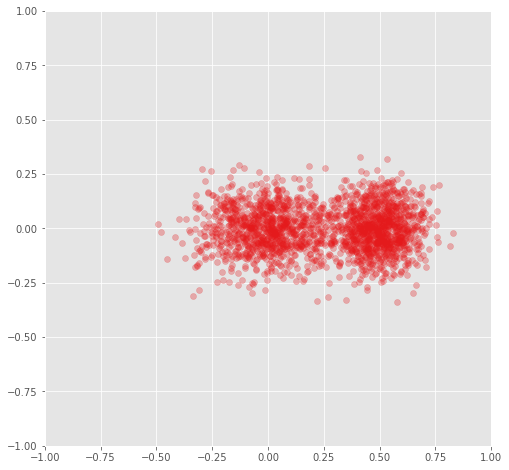

In [274]:

import matplotlib.cm as cmx


means = np.array([[0.5, 0.0],
                  [0, 0],
                  [-0.5, -0.5],
                  [-0.8, 0.3]])
covs = np.array([np.diag([0.01, 0.01]),
                 np.diag([0.025, 0.01]),
                 np.diag([0.01, 0.025]),
                 np.diag([0.01, 0.01])])

mu = means
stdev = covs
N=1000
w=nb_states

points = []
for i in range(len(means)):
    x = np.random.multivariate_normal(means[i], covs[i], N )
    points.append(x)
points = np.concatenate(points)


n_gaussians = mu.shape[1]
N = int(np.round(points.shape[0] / n_gaussians))
# Visualize data
fig = plt.figure(figsize=(8, 8))
axes = plt.gca()
axes.set_xlim([-1, 1])
axes.set_ylim([-1, 1])
plt.set_cmap('Set1')
colors = cmx.Set1(np.linspace(0, 1, n_gaussians))
for i in range(n_gaussians):
    idx = range(i * N, (i + 1) * N)
    plt.scatter(points[idx, 0], points[idx, 1], alpha=0.3, c=colors[i])
    for j in range(8):
        axes.add_patch(
            patches.Ellipse(mu[:, i], width=(j+1) * stdev[0, i], height=(j+1) *  stdev[1, i], fill=False, color=[0.0, 0.0, 1.0, 1.0/(0.5*j+1)]))
    plt.title('GMM')
plt.xlabel('X')
plt.ylabel('Y')

if export:
    if not os.path.exists('images/'): os.mkdir('images/')
    plt.savefig('images/2D_GMM_demonstration.png', dpi=100, format='png')

plt.show()

if export:
    if not os.path.exists('images/'): os.mkdir('images/')
    plt.savefig('images/2D_GMM_demonstration.png', dpi=100, format='png')

plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


TypeError: 'int' object is not subscriptable

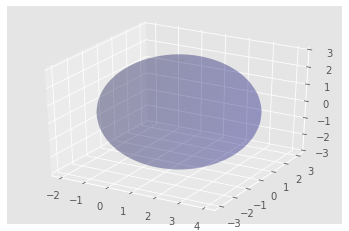

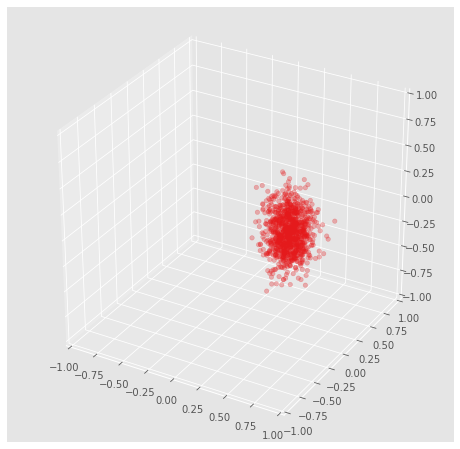

In [331]:
import matplotlib.cm as cmx

def plot_sphere(w=0, c=[0,0,0], r=[1, 1, 1], subdev=10, ax=None, sigma_multiplier=3):
    '''
        plot a sphere surface
        Input: 
            c: 3 elements list, sphere center
            r: 3 element list, sphere original scale in each axis ( allowing to draw elipsoids)
            subdiv: scalar, number of subdivisions (subdivision^2 points sampled on the surface)
            ax: optional pyplot axis object to plot the sphere in.
            sigma_multiplier: sphere additional scale (choosing an std value when plotting gaussians)
        Output:
            ax: pyplot axis object
    '''

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    pi = np.pi
    cos = np.cos
    sin = np.sin
    phi, theta = np.mgrid[0.0:pi:complex(0,subdev), 0.0:2.0 * pi:complex(0,subdev)]
    x = sigma_multiplier*r[0] * sin(phi) * cos(theta) + c[0]
    y = sigma_multiplier*r[1] * sin(phi) * sin(theta) + c[1]
    z = sigma_multiplier*r[2] * cos(phi) + c[2]
    cmap = cmx.ScalarMappable()
    cmap.set_cmap('jet')
    c = cmap.to_rgba(w)
    ax.plot_surface(x, y, z, color=c, alpha=0.2, linewidth=1)
    return ax


plot_sphere(w=0, c=[1,0,0], r=[1, 1, 1], subdev=50, ax=None, sigma_multiplier=3)


means = np.array([[0.5, 0.0, 0.0],
                  [0.0, 0.0, 0.0],
                  [-0.5, -0.5, -0.5],
                  [-0.8, 0.3, 0.4]])
covs = np.array([np.diag([0.01, 0.01, 0.03]),
                 np.diag([0.08, 0.01, 0.01]),
                 np.diag([0.01, 0.05, 0.01]),
                 np.diag([0.03, 0.07, 0.01])])

# visualization.visualize_3d_gmm(points, gmm.weights_, gmm.means_.T, np.sqrt(gmm.covariances_).T)

mu = means.T
stdev = covs
N=1000
n_gaussians = means.shape[0]
w=n_gaussians

points = []
for i in range(len(means)):
    x = np.random.multivariate_normal(means[i], covs[i], N )
    points.append(x)
points = np.concatenate(points)


n_gaussians = mu.shape[1]
N = int(np.round(points.shape[0] / n_gaussians))
# Visualize data
fig = plt.figure(figsize=(8, 8))
axes = fig.add_subplot(111, projection='3d')
axes.set_xlim([-1, 1])
axes.set_ylim([-1, 1])
axes.set_zlim([-1, 1])
plt.set_cmap('Set1')
colors = cmx.Set1(np.linspace(0, 1, n_gaussians))
for i in range(n_gaussians):
    idx = range(i * N, (i + 1) * N)
    axes.scatter(points[idx, 0], points[idx, 1], points[idx, 2], alpha=0.3, c=colors[i])
    plot_sphere(w=w[i], c=mu[:, i], r=stdev[:, i], ax=axes)

plt.title('3D GMM')
axes.set_xlabel('X')
axes.set_ylabel('Y')
axes.set_zlabel('Z')
axes.view_init(35.246, 45)
if export:
    if not os.path.exists('images/'): os.mkdir('images/')
    plt.savefig('images/3D_GMM_demonstration.png', dpi=100, format='png')
plt.show()


/home/hulk/.local/lib/python3.5/site-packages/ipykernel_launcher.py:101: RuntimeWarning: covariance is not positive-semidefinite.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


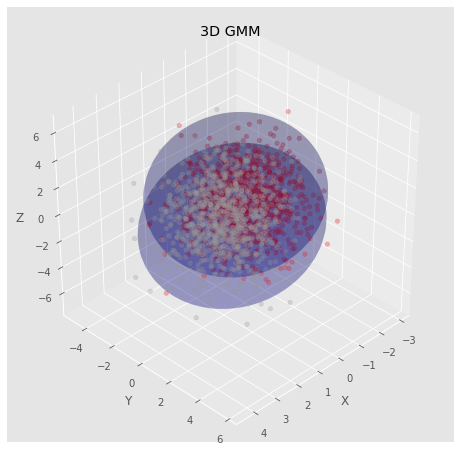

In [367]:
import numpy as np
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import os


def visualize_3d_gmm(points, w, mu, stdev, export=True):
    '''
    plots points and their corresponding gmm model in 3D
    Input: 
        points: N X 3, sampled points
        w: n_gaussians, gmm weights
        mu: 3 X n_gaussians, gmm means
        stdev: 3 X n_gaussians, gmm standard deviation (assuming diagonal covariance matrix)
    Output:
        None
    '''

    n_gaussians = mu.shape[1]
    N = int(np.round(points.shape[0] / n_gaussians))
    # Visualize data
    fig = plt.figure(figsize=(8, 8))
    axes = fig.add_subplot(111, projection='3d')
#     axes.set_xlim([-1, 1])
#     axes.set_ylim([-1, 1])
#     axes.set_zlim([-1, 1])
    plt.set_cmap('Set1')
    colors = cmx.Set1(np.linspace(0, 1, n_gaussians))
    for i in range(n_gaussians):
        idx = range(i * N, (i + 1) * N)
        axes.scatter(points[idx, 0], points[idx, 1], points[idx, 2], alpha=0.3, c=colors[i])
        plot_sphere(w=w[i], c=mu[:, i], r=stdev[:, i], ax=axes)

    plt.title('3D GMM')
    axes.set_xlabel('X')
    axes.set_ylabel('Y')
    axes.set_zlabel('Z')
    axes.view_init(35.246, 45)
    if export:
        if not os.path.exists('images/'): os.mkdir('images/')
        plt.savefig('images/3D_GMM_demonstration.png', dpi=100, format='png')
    plt.show()


def plot_sphere(w=0, c=[0,0,0], r=[1, 1, 1], subdev=50, ax=None, sigma_multiplier=3):
    '''
        plot a sphere surface
        Input: 
            c: 3 elements list, sphere center
            r: 3 element list, sphere original scale in each axis ( allowing to draw elipsoids)
            subdiv: scalar, number of subdivisions (subdivision^2 points sampled on the surface)
            ax: optional pyplot axis object to plot the sphere in.
            sigma_multiplier: sphere additional scale (choosing an std value when plotting gaussians)
        Output:
            ax: pyplot axis object
    '''

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    pi = np.pi
    cos = np.cos
    sin = np.sin
    phi, theta = np.mgrid[0.0:pi:complex(0,subdev), 0.0:2.0 * pi:complex(0,subdev)]
    x = sigma_multiplier*r[0] * sin(phi) * cos(theta) + c[0]
    y = sigma_multiplier*r[1] * sin(phi) * sin(theta) + c[1]
    z = sigma_multiplier*r[2] * cos(phi) + c[2]
    cmap = cmx.ScalarMappable()
    cmap.set_cmap('jet')
    c = cmap.to_rgba(w)

    ax.plot_surface(x, y, z, color=c, alpha=0.2, linewidth=1)

    return ax



## Generate synthetic data
N,D = 1000, 2 # number of points and dimenstinality

# set gaussian ceters and covariances in 3D
means = np.array([[0, 0.0, 0.0],
                 [1, 0.0, 0.0]])
covs = np.array([np.array([   [1, 0.0, 1.0],
                              [0.0, 2, 1.0],
                              [0.0, 0.0, 4]]),
                 np.diag(     [1, 2, 4])])

# means = savedmu
# covs = savedsigma


n_gaussians = means.shape[0]

points = []
for i in range(len(means)):
    x = np.random.multivariate_normal(means[i], covs[i], N )
    points.append(x)
points = np.concatenate(points)

#fit the gaussian model
gmm = GaussianMixture(n_components=n_gaussians, covariance_type='diag')
gmm.fit(points)

visualize_3d_gmm(points, gmm.weights_, gmm.means_.T, np.sqrt(gmm.covariances_).T)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
EM converges
EM converges


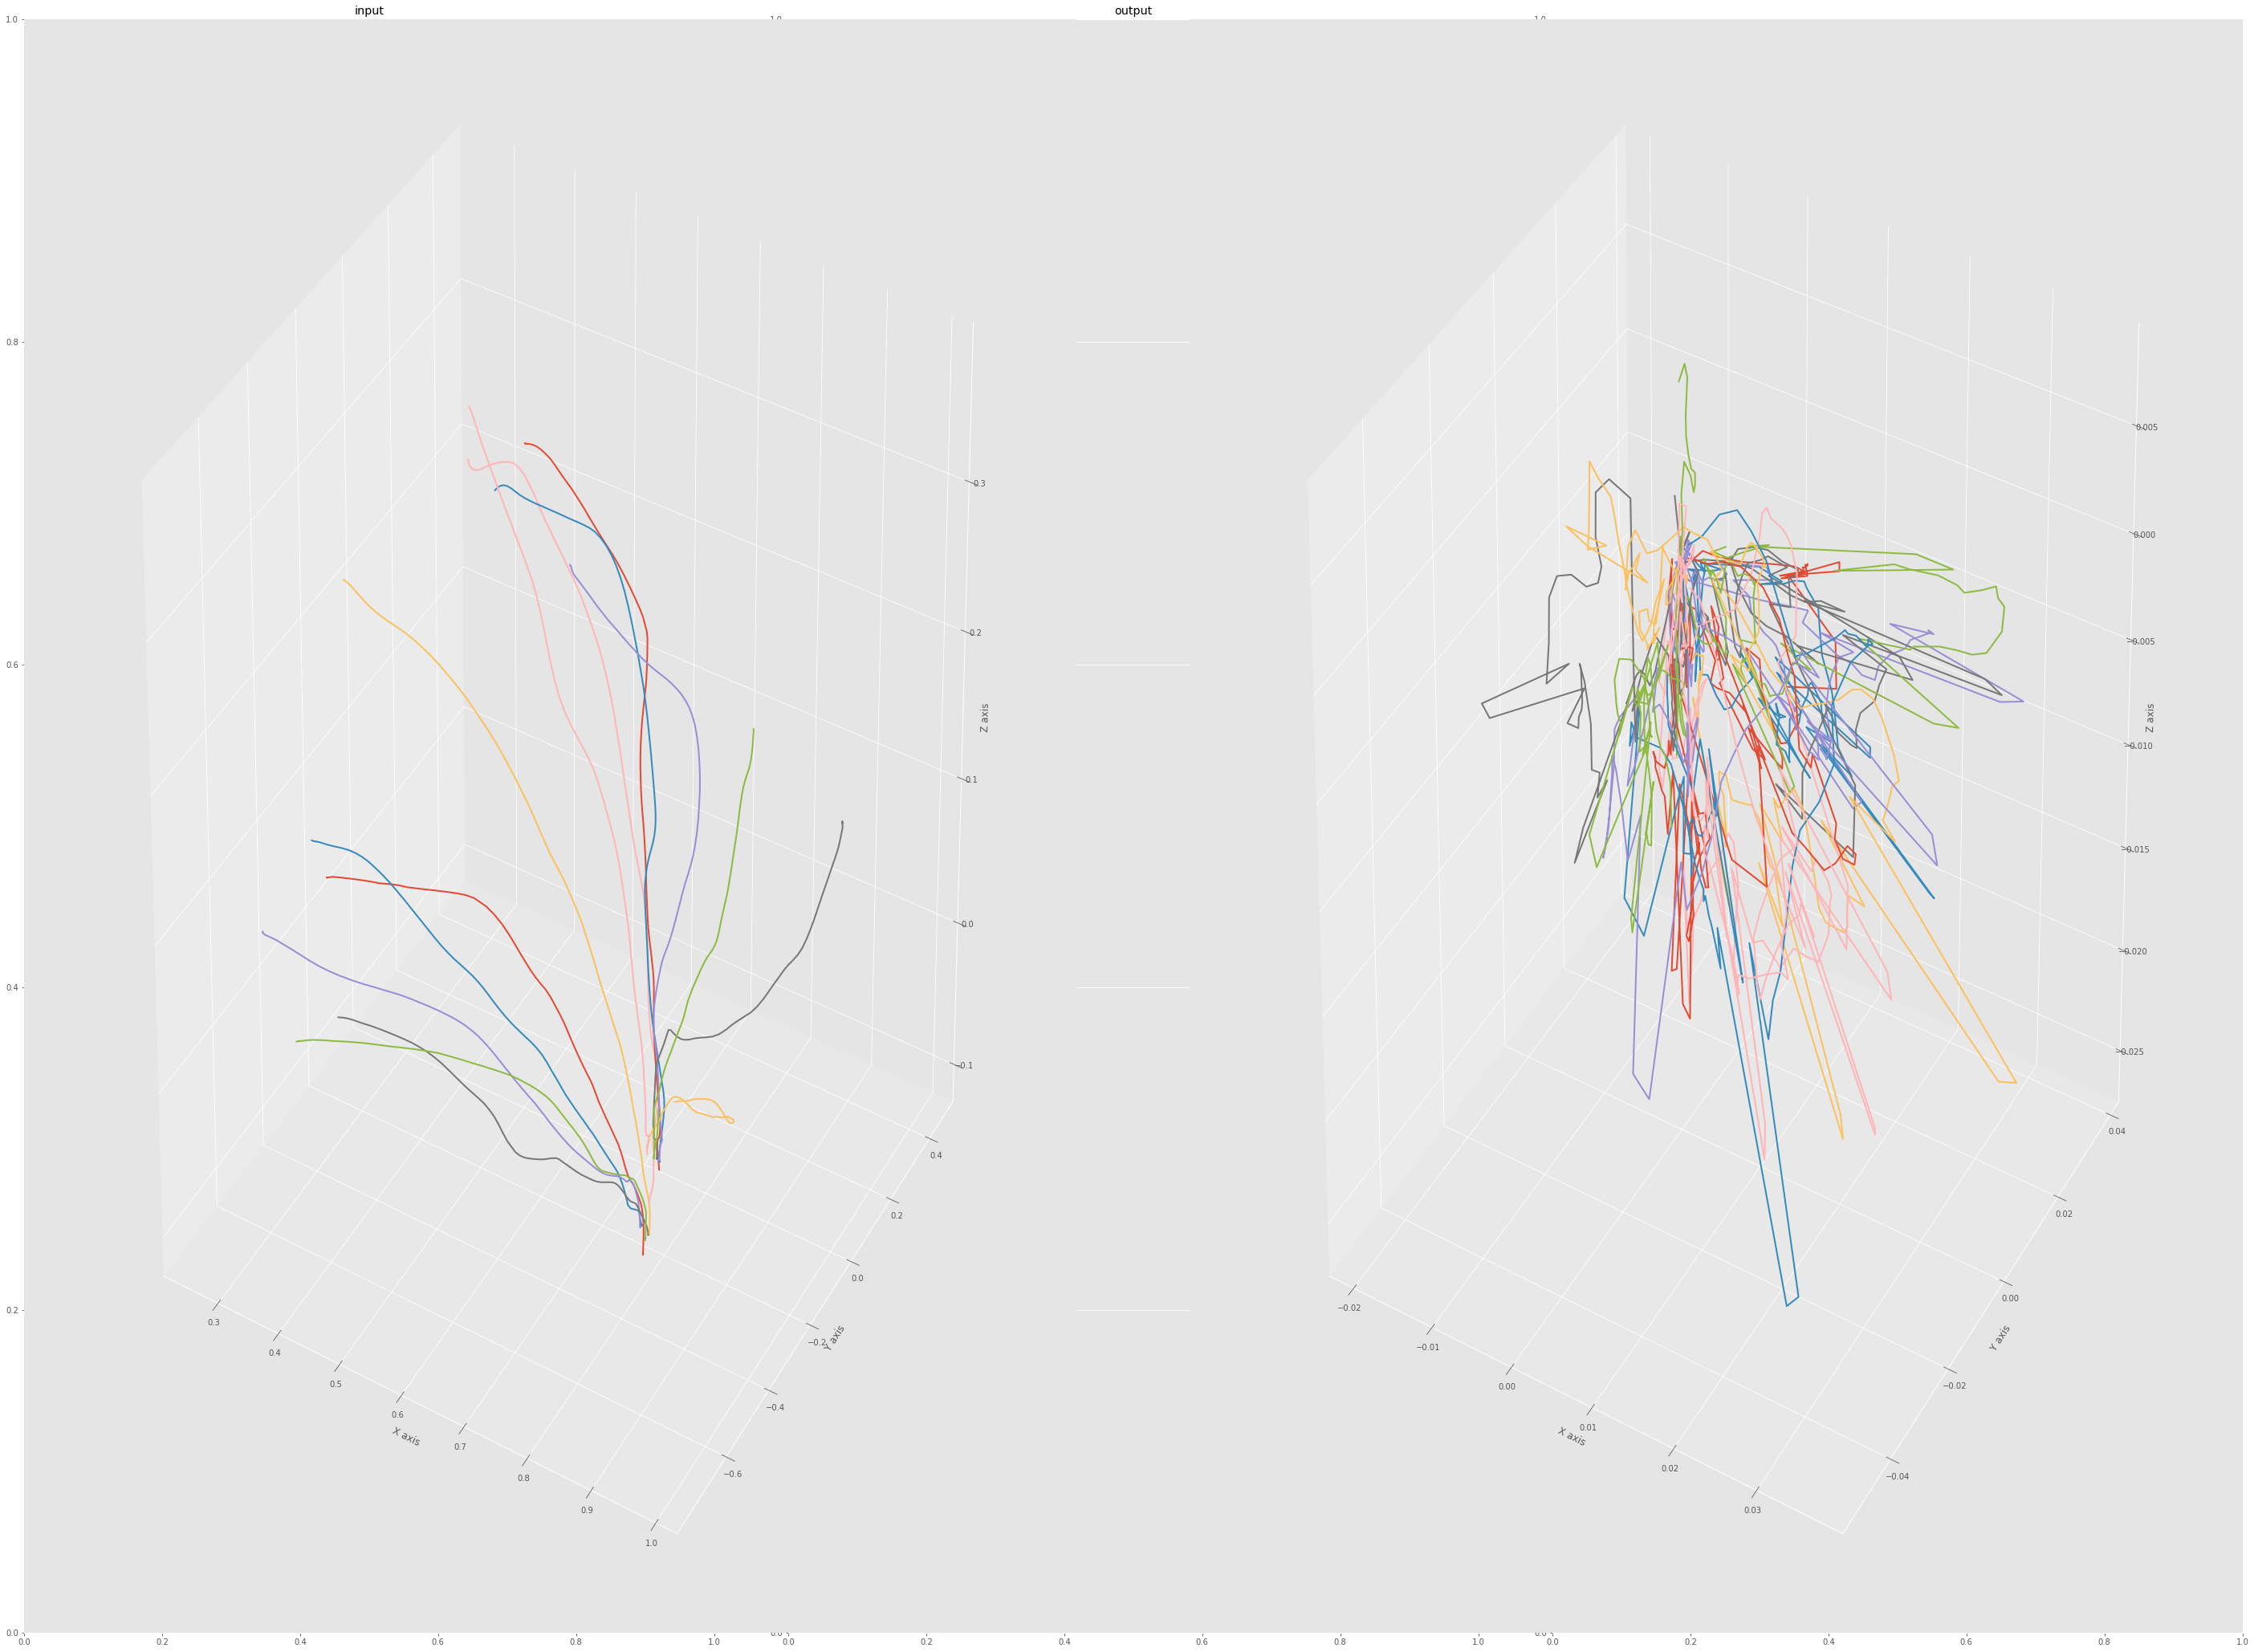

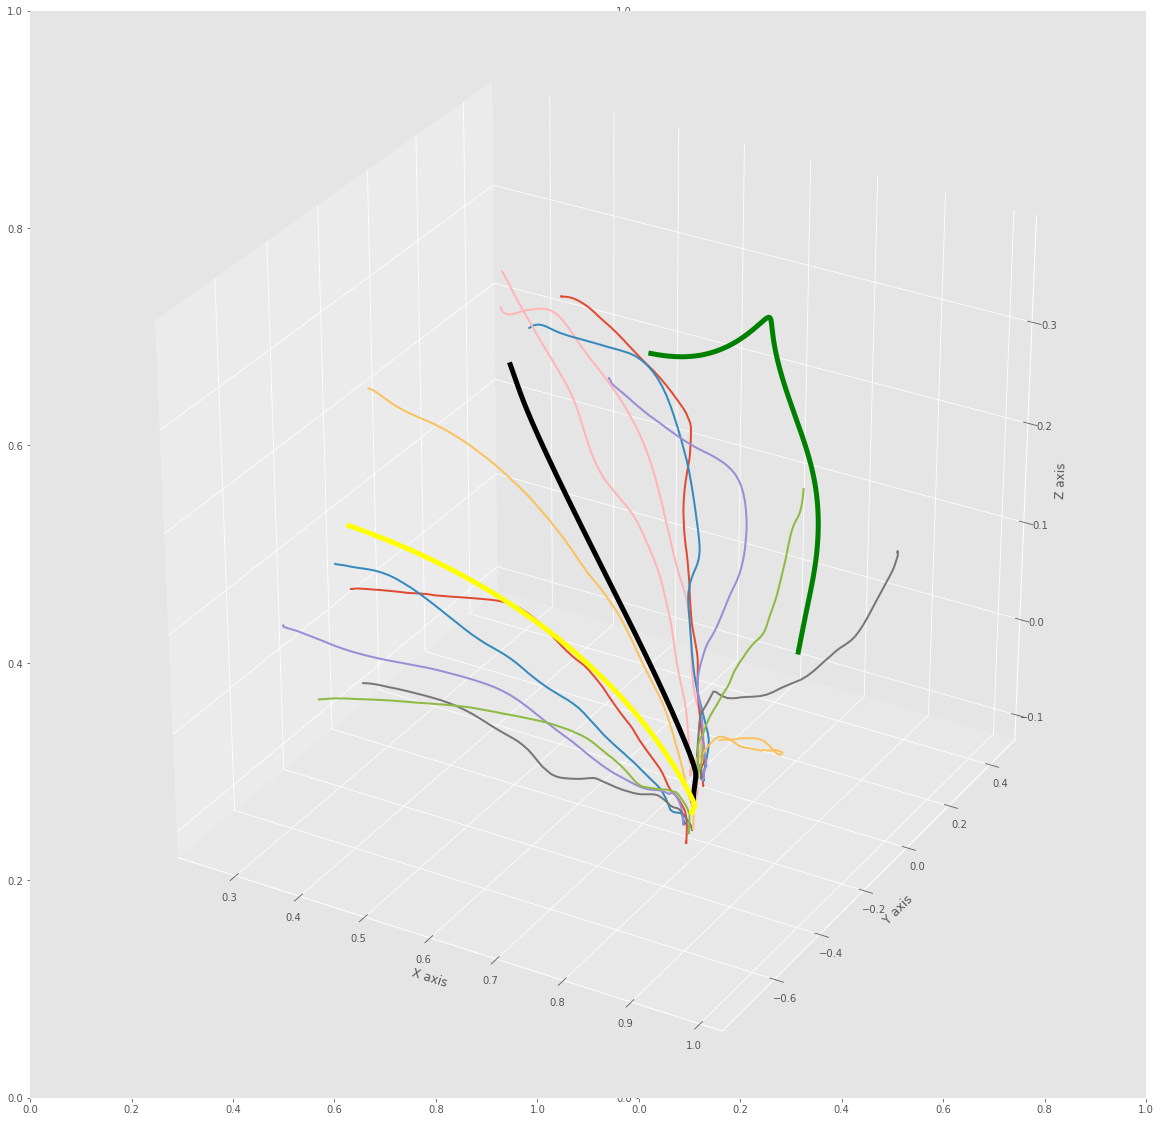

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat # loading data from matlab
from mpl_toolkits.mplot3d import Axes3D

import os
# import pbdlib as pbd
# import pbdlib.plot 
# from pbdlib.utils.jupyter_utils import *
np.set_printoptions(precision=2)

from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import os

%matplotlib inline
%load_ext autoreload
%autoreload 2

num_traj = 14

nb_states = 3  # choose the number of states in HMM or clusters in GMM

num_traj_points = 600

# %reset

letter_in = 'new_traj' # INPUT LETTER: choose a letter in the alphabet

datapath = os.path.dirname(pbd.__file__) + '/data/RobotData/'

data_in = loadmat(datapath + '%s.mat' % letter_in)

demos_in = [d['pos'][0][0].T for d in data_in['posdemos'][0]] # cleaning matlab data
demos_out = [d['vel'][0][0].T for d in data_in['veldemos'][0]] # cleaning matlab data

demos = [np.concatenate([d_in, d_out], axis=1) 
         for d_in, d_out in zip(demos_in, demos_out)]

fig, ax = plt.subplots(ncols=3)
fig.set_size_inches(18., 8.5)
plt.tight_layout()

[ax[i].set_title(s) for i, s in enumerate(['input', 'output'])]

ax = fig.add_subplot(1,2,1, projection = '3d')
B = np.arange(num_traj)
for l in B:
    x = np.array(demos_in[l])
    xp = x[:,0]
    yp = x[:,1]
    zp = x[:,2]  
    
    ax.plot3D(xp,yp,zp, linewidth = 2, antialiased=True)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

ax = fig.add_subplot(1,2,2, projection = '3d')
B = np.arange(num_traj)
for l in B:
    x = np.array(demos_out[l])
    xp = x[:,0]
    yp = x[:,1]
    zp = x[:,2]  

    ax.plot3D(xp,yp,zp, linewidth = 2, antialiased=True)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    # plt.tight_layout()   


np.stack(demos).shape


# creating models
gmm = pbd.GMM(nb_states=nb_states)
hmm = pbd.HMM(nb_states=nb_states)
hsmm = pbd.HSMM(nb_states=nb_states)

# initializing model by splitting the demonstrations in k bins
[model.init_hmm_kbins(demos) for model in [gmm, hmm, hsmm]] 

# EM to train model
gmm.em(np.concatenate(demos), reg=1e-8) 
hmm.em(np.stack(demos), reg=1e-8) 
hsmm.em(demos, reg=1e-6) 

#THIS IS THE SAVED SIGMA AND MU VALUES
savedsigma = gmm.sigma
savedmu = gmm.mu

file1 = open("/home/hulk/Documents/waypoints/f1.txt","w") 


from numpy import array
y = array([.5,.1,.1])

y.shape = (1,3)

mu_est_gmm, sigma_est_gmm = gmm.condition(
    y, dim_in=slice(0, 3), dim_out=slice(3, 6))

mu_est_hmm, sigma_est_hmm = hmm.condition(
    y, dim_in=slice(0, 3), dim_out=slice(3, 6))



fig.set_size_inches(40, 30)


y = array([.5,-.2,.3])
y.shape = (1,3)

#CAN CHANGE DELTA VALUE HERE
delt = .1
pos = array([0,0,0])
pos.shape = (1,3)
pos = y + mu_est_gmm*delt

#3D VERSION
A = np.arange(num_traj_points)
for j in A:
    temp = pos[j]
    temp.shape = (1,3) 
    mu_est_gmm, sigma_est_gmm = gmm.condition(temp, dim_in=slice(0, 3), dim_out=slice(3, 6))
    newpos = temp + mu_est_gmm*delt
    newpos.shape = (1,3)
    finalresult = np.concatenate((pos,newpos),axis=0)
    pos = finalresult
    # L = np.array2string(newpos, precision=2, separator=',', suppress_small=True)  
    # file1.writelines(L)
    # file1.write("\n")

file1.write("\n")


fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(20., 20)
ax = fig.add_subplot(1,1,1, projection = '3d')

C = np.arange(num_traj)
for m in C:
    x = np.array(demos_in[m])
    xp = x[:,0]
    yp = x[:,1]
    zp = x[:,2]  
    ax.plot3D(xp,yp,zp, linewidth = 2, antialiased=True)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

pos1 = pos    
ax.plot3D(pos[:,0],pos[:,1],pos[:,2],linewidth = 5, color='black')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

L = np.array2string(pos1, precision=2, separator=',', suppress_small=True)  
file1.writelines(L)
file1.write("\n")

y = array([.5,.4,.2])
y.shape = (1,3)
mu_est_gmm, sigma_est_gmm = gmm.condition(
    y, dim_in=slice(0, 3), dim_out=slice(3, 6))

pos = array([0,0,0])
pos.shape = (1,3)
pos = y + mu_est_gmm*delt


for j in A:
    temp = pos[j]
    temp.shape = (1,3) 
    mu_est_gmm, sigma_est_gmm = gmm.condition(temp, dim_in=slice(0, 3), dim_out=slice(3, 6))
    newpos = temp + mu_est_gmm*delt
    newpos.shape = (1,3)
    finalresult = np.concatenate((pos,newpos),axis=0)
    pos = finalresult
    L = np.array2string(newpos, precision=2, separator=',', suppress_small=True)  
    file1.writelines(L)
    file1.write("\n")

pos2 = pos
ax.plot3D(pos[:,0],pos[:,1],pos[:,2],linewidth = 5, color='green')

L = np.array2string(pos2, precision=2, separator=',', suppress_small=True)  
file1.writelines(L)
file1.write("\n")



y = array([.7,-.3,.1])
y.shape = (1,3)
mu_est_gmm, sigma_est_gmm = gmm.condition(
    y, dim_in=slice(0, 3), dim_out=slice(3, 6))

pos = array([0,0,0])
pos.shape = (1,3)
pos = y + mu_est_gmm*delt



y = array([.4,-.6,.2])
y.shape = (1,3)
mu_est_gmm, sigma_est_gmm = gmm.condition(
    y, dim_in=slice(0, 3), dim_out=slice(3, 6))


pos = array([0,0,0])
pos.shape = (1,3)
pos = y + mu_est_gmm*delt


for j in A:
    temp = pos[j]
    temp.shape = (1,3) 
    mu_est_gmm, sigma_est_gmm = gmm.condition(temp, dim_in=slice(0, 3), dim_out=slice(3, 6))
    newpos = temp + mu_est_gmm*delt
    newpos.shape = (1,3)
    finalresult = np.concatenate((pos,newpos),axis=0)
    pos = finalresult

pos3=pos
ax.plot3D(pos[:,0],pos[:,1],pos[:,2],linewidth = 5, color='yellow')


L = np.array2string(pos3, precision=2, separator=',', suppress_small=True)  
file1.writelines(L)
file1.write("\n")

file1.close() 



'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


[0.38 0.33 0.28]


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


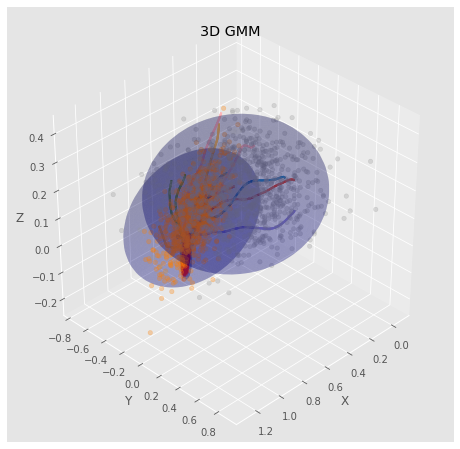

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


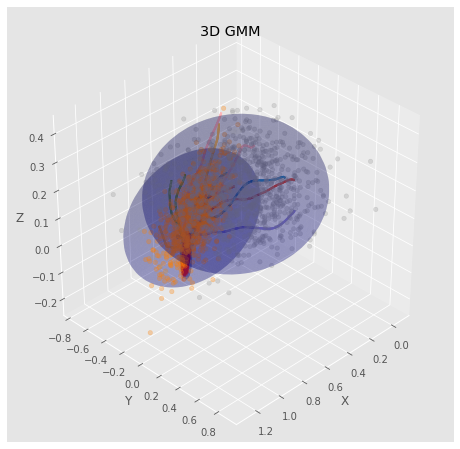

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


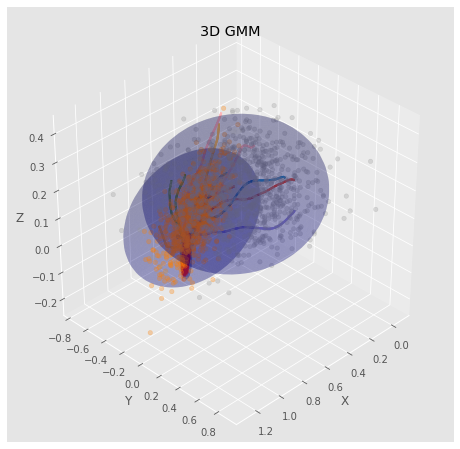

In [26]:
#VISUALISING GMM
#PLOTTING
def visualize_3d_gmm(points, w, mu, stdev, export=True):

    n_gaussians = mu.shape[1]
    N = int(np.round(points.shape[0] / n_gaussians))
    # Visualize data
    fig = plt.figure(figsize=(8, 8))
    axes = fig.add_subplot(111, projection='3d')

    plt.set_cmap('Set1')
    colors = cmx.Set1(np.linspace(0, 1, n_gaussians))
    for i in range(n_gaussians):
        idx = range(i * N, (i + 1) * N)
        axes.scatter(points[idx, 0], points[idx, 1], points[idx, 2], alpha=0.3, c=colors[i])
        plot_sphere(w=w[i], c=mu[:, i], r=stdev[:, i], ax=axes)

    plt.title('3D GMM')
    axes.set_xlabel('X')
    axes.set_ylabel('Y')
    axes.set_zlabel('Z')
    axes.view_init(35.246, 45)
    if export:
        if not os.path.exists('images/'): os.mkdir('images/')
        plt.savefig('images/3D_GMM_demonstration.png', dpi=100, format='png')
    plt.show()


def plot_sphere(w=0, c=[0,0,0], r=[1, 1, 1], subdev=50, ax=None, sigma_multiplier=3):

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    pi = np.pi
    cos = np.cos
    sin = np.sin
    phi, theta = np.mgrid[0.0:pi:complex(0,subdev), 0.0:2.0 * pi:complex(0,subdev)]
    x = sigma_multiplier*r[0] * sin(phi) * cos(theta) + c[0]
    y = sigma_multiplier*r[1] * sin(phi) * sin(theta) + c[1]
    z = sigma_multiplier*r[2] * cos(phi) + c[2]
    cmap = cmx.ScalarMappable()
    cmap.set_cmap('jet')
    c = cmap.to_rgba(w)

    ax.plot_surface(x, y, z, color=c, alpha=0.2, linewidth=1)

    # plt.tight_layout()
    B = np.arange(num_traj)
    for l in B:
        x = np.array(demos_in[l])
        xp = x[:,0]
        yp = x[:,1]
        zp = x[:,2]  

        ax.plot3D(xp,yp,zp, linewidth = 2, antialiased=True)
        ax.set_xlabel('X axis')
        ax.set_ylabel('Y axis')
        ax.set_zlabel('Z axis')

    return ax



## Generate synthetic data
N,D = 1000, 2 # number of points and dimenstinality

means = savedmu
covs = savedsigma


n_gaussians = means.shape[0]

points = []
for i in range(len(means)):
    x = np.random.multivariate_normal(means[i], covs[i], N )
    points.append(x)
points = np.concatenate(points)

#fit the gaussian model
gmm = GaussianMixture(n_components=n_gaussians, covariance_type='diag')
gmm.fit(points)

print(gmm.weights_)
# print(gmm.priors)

weight = [0, 0, 1]
visualize_3d_gmm(points, weight, gmm.means_.T, np.sqrt(gmm.covariances_).T)

weight = [0, 1, 0]
visualize_3d_gmm(points, weight, gmm.means_.T, np.sqrt(gmm.covariances_).T)

weight = [1, 0, 0]
visualize_3d_gmm(points, weight, gmm.means_.T, np.sqrt(gmm.covariances_).T)

In [34]:
print(gmm.sigma)

[[[ 1.90e-04  1.46e-04  8.77e-05 -2.00e-05 -9.53e-06  1.65e-06]
  [ 1.46e-04  2.30e-04  3.13e-04 -1.35e-05 -1.09e-05 -1.19e-05]
  [ 8.77e-05  3.13e-04  8.67e-04 -5.96e-06 -8.67e-06 -3.87e-05]
  [-2.00e-05 -1.35e-05 -5.96e-06  4.08e-06  7.91e-07 -1.52e-06]
  [-9.53e-06 -1.09e-05 -8.67e-06  7.91e-07  2.33e-06  1.20e-06]
  [ 1.65e-06 -1.19e-05 -3.87e-05 -1.52e-06  1.20e-06  1.05e-05]]

 [[ 3.13e-02  1.41e-02 -2.91e-03 -9.70e-04 -5.73e-04 -2.64e-04]
  [ 1.41e-02  1.89e-02  1.45e-03 -5.70e-04 -1.19e-03 -2.57e-04]
  [-2.91e-03  1.45e-03  5.38e-03  1.14e-04 -1.78e-04 -1.26e-04]
  [-9.70e-04 -5.70e-04  1.14e-04  8.67e-05  4.17e-05 -5.87e-06]
  [-5.73e-04 -1.19e-03 -1.78e-04  4.17e-05  1.16e-04  1.06e-05]
  [-2.64e-04 -2.57e-04 -1.26e-04 -5.87e-06  1.06e-05  2.50e-05]]

 [[ 3.88e-02 -1.90e-02 -5.95e-03 -8.36e-04 -3.67e-04 -2.45e-04]
  [-1.90e-02  4.21e-02 -6.91e-03  4.91e-04 -2.58e-04  6.62e-04]
  [-5.95e-03 -6.91e-03  4.73e-03  1.11e-04  2.95e-04 -6.57e-05]
  [-8.36e-04  4.91e-04  1.11e-04  8.

In [20]:
savedsigma

array([[[ 3.20e-04,  2.20e-04,  1.31e-04, -3.90e-05, -1.90e-05,
          2.47e-06],
        [ 2.20e-04,  2.82e-04,  3.37e-04, -2.41e-05, -1.92e-05,
         -1.17e-05],
        [ 1.31e-04,  3.37e-04,  1.03e-03, -1.65e-05, -1.14e-05,
         -4.75e-05],
        [-3.90e-05, -2.41e-05, -1.65e-05,  7.07e-06,  1.90e-06,
         -1.56e-06],
        [-1.90e-05, -1.92e-05, -1.14e-05,  1.90e-06,  3.81e-06,
          1.28e-06],
        [ 2.47e-06, -1.17e-05, -4.75e-05, -1.56e-06,  1.28e-06,
          1.09e-05]],

       [[ 3.48e-02,  1.77e-03, -4.79e-03, -9.66e-04, -4.57e-04,
         -2.96e-04],
        [ 1.77e-03,  6.25e-02,  1.20e-02, -1.24e-06, -1.91e-03,
          1.09e-04],
        [-4.79e-03,  1.20e-02,  9.53e-03,  2.03e-04, -3.65e-04,
         -6.23e-05],
        [-9.66e-04, -1.24e-06,  2.03e-04,  8.99e-05,  1.56e-05,
         -5.53e-06],
        [-4.57e-04, -1.91e-03, -3.65e-04,  1.56e-05,  1.41e-04,
          7.53e-06],
        [-2.96e-04,  1.09e-04, -6.23e-05, -5.53e-06,  7.53e-06,

In [24]:
savedsigma[1,0,0]

0.03482831484193069